In [1]:
import geopandas as gpd
import seaborn as sns
import libpysal as lps
from libpysal.weights import Queen
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pysal.viz as viz
from pysal.explore import esda 

from pysal.model.spreg import ols
from scipy.stats import pearsonr
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')

In [2]:
# load msoa atlas
msoa = gpd.read_file('./data/Borough_boundary/Borough_boundary.shp')
msoa.plot()

DriverError: ./data/Borough_boundary/Borough_boundary.shp: No such file or directory

In [4]:
# explore the information of msoa
msoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    33 non-null     int64   
 1   BOROUGH     33 non-null     object  
 2   NUMBER      33 non-null     object  
 3   NAME        33 non-null     object  
 4   AREA_CODE   33 non-null     object  
 5   DESCRIPTIO  33 non-null     object  
 6   Shape_Leng  33 non-null     float64 
 7   Shape_Area  33 non-null     float64 
 8   geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 2.4+ KB


In [3]:
# drop useless attributes
msoa.drop(['NUMBER0', 'FILE_NAME', 'NUMBER1', 'POLYGON_ID', 'UNIT_ID', 'CODE',
       'HECTARES', 'AREA','TYPE_CODE', 'DESCRIPT0', 'NUMBER_NW', 'NUMBER_N', 'NUMBER_NE', 'NUMBER_W',
       'NUMBER_E', 'NUMBER_SW', 'NUMBER_S', 'NUMBER_SE'],axis=1, inplace=True)

# 2.1	Factors selection
## A. Data processing

In [38]:
# read the london housing data
df_data = pd.read_csv('./data/Housing_data.csv')
df_data.info()
"""
TotalHS2020: Housing sales in 2020
AvHP2020: Average housing price in 2020
Crime2020: Crime number in 2020
TotalRL2020: The total length of road network
AvPTAI2015: The accessibility of public transportations
Per_GB: The green & blue infrastructure cover (per km square)
AvIncome: Average income in 2017-2018
Area: The sized area of each Borough
Census2011: The census in 2011
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Code         33 non-null     object 
 1   Borough      33 non-null     object 
 2   TotalHS2020  33 non-null     int64  
 3   AvHP2020     33 non-null     float64
 4   Crime2020    33 non-null     int64  
 5   TotalRL2020  33 non-null     float64
 6   AvPTAI2015   33 non-null     float64
 7   Per_GB       33 non-null     float64
 8   AvIncome     33 non-null     int64  
 9   Area         33 non-null     float64
 10  Census2011   33 non-null     int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 3.0+ KB


In [39]:
# find the Non-value
df_data.isnull()

,Code,Borough,TotalHS2020,AvHP2020,Crime2020,TotalRL2020,AvPTAI2015,Per_GB,AvIncome,Area,Census2011
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False


In [40]:
# obtain the statistic information of data set
df_data.describe()

,TotalHS2020,AvHP2020,Crime2020,TotalRL2020,AvPTAI2015,Per_GB,AvIncome,Area,Census2011
count,33.000000,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1837.181818,5.378671e+05,31709.484848,54.903030,14.022116,0.469114,54890.909091,47.640823,247700.000000
std,672.972578,2.092508e+05,11038.022304,20.945398,16.178179,0.117215,34103.274803,32.709137,69488.964951
min,90.000000,3.026388e+05,5925.000000,12.400000,2.747859,0.133111,27400.000000,2.903934,7400.000000
25%,1426.000000,4.092900e+05,22831.000000,38.700000,5.542330,0.409677,36200.000000,26.810035,206100.000000
50%,1773.000000,4.814609e+05,33156.000000,55.100000,8.503510,0.452993,43100.000000,37.624738,254100.000000
75%,2207.000000,5.833085e+05,40326.000000,62.800000,17.478762,0.549767,54600.000000,56.418997,303100.000000
max,3634.000000,1.329851e+06,56058.000000,109.200000,90.802508,0.694912,177000.000000,150.134892,363400.000000


In [9]:
# calculate the crime rate(per 1000)
df_data['Crime2020'] = df_data.apply (lambda x: x['Crime2020'] / x['Census2011'] * 1000, axis = 1)
# calculate the density of road network
df_data['TotalRL2020'] = df_data.apply (lambda x: x['TotalRL2020'] / x['Area'], axis = 1)

In [10]:
# join these two datasets
db = df_data.join(msoa.set_index(['BOROUGH']), on=['Borough'], how='left')
db.shape

(33, 19)

In [17]:
# save the shapefile into local machine
db_geo = gpd.GeoDataFrame(db, geometry='geometry')
db_geo.to_file(driver='ESRI Shapefile', filename='./data/msoa_housing.shp')
# read data in a geopandas dataframe
gdf_house = gpd.read_file('./data/msoa_housing.shp')
gdf_house.head()

,Code,Borough,TotalHS202,AvHP2020,Crime2020,TotalRL202,AvPTAI2015,Per_GB,AvIncome,Area,Census2011,OBJECTID,NUMBER,NAME,AREA_CODE,DESCRIPTIO,Shape_Leng,Shape_Area,geometry
0,E09000002,Barking and Dagenham,1078,302638.7861,130.973642,1.033017,5.583730,0.452993,27400,36.107817,185900,1,16,Barking and Dagenham London Boro,LBO,London Borough,36929.734218,3.777897e+07,"POLYGON ((549895.001 181460.618, 549883.705 18..."
1,E09000003,Barnet,2391,526648.9521,106.324355,1.258814,5.542330,0.586861,49500,86.748314,356400,2,30,Barnet London Boro,LBO,London Borough,50866.471790,8.673726e+07,"POLYGON ((524579.900 198355.223, 524594.304 19..."
2,E09000004,Bexley,2356,343533.4689,91.500000,1.140628,4.552927,0.497241,33500,60.580668,232000,3,18,Bexley London Boro,LBO,London Borough,43329.234247,6.426334e+07,"POLYGON ((547448.007 170380.319, 547413.204 17..."
3,E09000005,Brent,1284,486627.7874,129.675450,1.293005,9.223249,0.409677,35400,43.232637,311200,4,28,Brent London Boro,LBO,London Borough,38354.620389,4.323538e+07,"POLYGON ((515767.199 186062.821, 515860.006 18..."
4,E09000006,Bromley,3634,436562.4385,95.892049,0.599461,3.592084,0.687355,45500,150.134892,309400,5,19,Bromley London Boro,LBO,London Borough,75909.142764,1.501452e+08,"POLYGON ((540373.604 157530.416, 540361.203 15..."


# 3.	Findings & Discussion
## 3.1	 An assessment of residential preference

In [18]:
# define the max-min normalization function
def MinMaxNorm(gdf):
    new_gdf = (gdf - gdf.min()) / (gdf.max()-gdf.min())  
    return new_gdf

In [19]:
# normalize all factors
for i in range(3, 9):
    gdf_house.iloc[:,i] =  MinMaxNorm(gdf_house.iloc[:,i])

In [27]:
x = ['AvHP2020', 'Crime2020', 'TotalRL202', 'AvPTAI2015', 'Per_GB', 'AvIncome'] # define input/independant variables
X = gdf_house.loc[:, x].dropna()

In [21]:
# compute the index HPI
df_index = ((gdf_house['AvHP2020'] * -0.30) # housing price with weight of (-0.30) 
+ (gdf_house['Crime2020'] * -0.25) # crime rate with weight of (-0.25) 
+ (gdf_house['AvPTAI2015']*0.10+ gdf_house['TotalRL202']*0.10) # accessibility of public tranports and density of road network with two weights of 0.10
+ (gdf_house['Per_GB'] * 0.15) # green & blue infrastucture cover rate with weight of (-0.30) 
+ (gdf_house['AvIncome'] * 0.10)) # average income with weight of (-0.30) 

In [23]:
# create a new column with values of HPI 
gdf_house.insert(3, 'HPI', df_index)

### OLS regression

In [25]:
# using ordinary least square (OLS) regression to test the feasibility of HPIs
x = ['HPI'] # define input variable: HPI
X = gdf_house.loc[:, x].dropna() # drop Non-value
y = np.array(gdf_house['TotalHS202']) # define output variable: housing sales

model = sm.OLS(y, X).fit() # fit model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.658
Model:                            OLS   Adj. R-squared (uncentered):              0.647
Method:                 Least Squares   F-statistic:                              61.56
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    5.96e-09
Time:                        00:52:18   Log-Likelihood:                         -279.17
No. Observations:                  33   AIC:                                      560.3
Df Residuals:                      32   BIC:                                      561.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HPI         2.037e+04   2596.564      7.846      0.000    1.51e+04    2.57e+04
==============================================================================
Omnibus:                        0.844   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.721
Skew:                           0.341   Prob(JB):                        0.697
Kurtosis:                       2.753   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

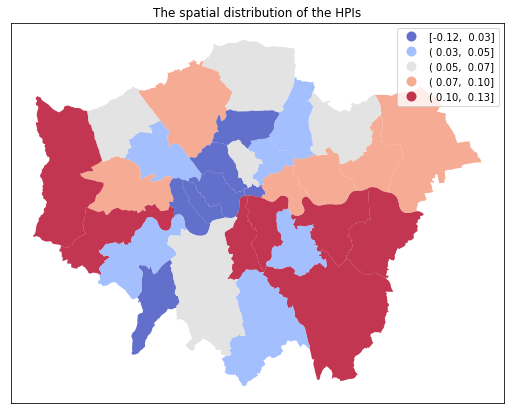

In [121]:
# plot the spatial distribution of the HPIs
gdf_house.plot(column='HPI', alpha=0.8,cmap='coolwarm', scheme='quantiles',  legend = True,figsize = (14,7))
plt.title("The spatial distribution of the HPIs") # set title
plt.gca().xaxis.set_major_locator(plt.NullLocator())# delete the x-axis
plt.gca().yaxis.set_major_locator(plt.NullLocator())# delete the y-axis
plt.savefig('./Figures/spatial_distribution_HIPs.png')

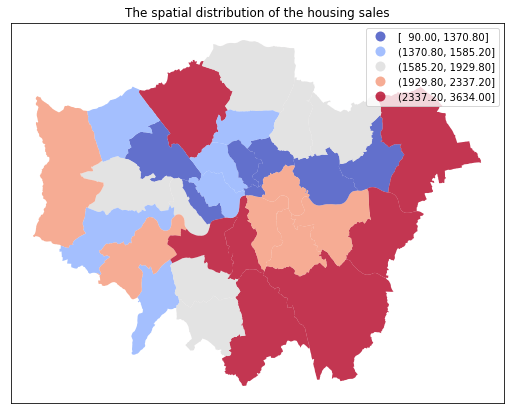

In [120]:
# plot the spatial distribution of the housing sales
gdf_house.plot(column='TotalHS202', alpha=0.8,cmap='coolwarm', scheme='quantiles',  legend = True,figsize = (14,7))
plt.title("The spatial distribution of the housing sales") # set title
plt.gca().xaxis.set_major_locator(plt.NullLocator())# delete the x-axis
plt.gca().yaxis.set_major_locator(plt.NullLocator())# delete the y-axis
plt.savefig('./Figures/spatial_distribution_HS.png')

## 3.2	 Spatial distribution of the HPI
### Global Moran's I

In [82]:
# Create the spatial weights matrix by Queen
w_queen = Queen.from_dataframe(gdf_house)

In [83]:
gdf_house.to_file(driver='ESRI Shapefile', filename='./data/housing_HPI.shp')

In [86]:
gdf_house.to_file(driver='ESRI Shapefile', filename='./data/housing_HPI.shp')
W_queen = ps.lib.weights.Queen.from_shapefile('data/housing_HPI.shp')
W_queen.transform = 'r' # row-standardize the contiguity weights
HPI_Lag = ps.lib.weights.lag_spatial(W_queen, gdf_house['HPI']) #spatial lag of the HPI

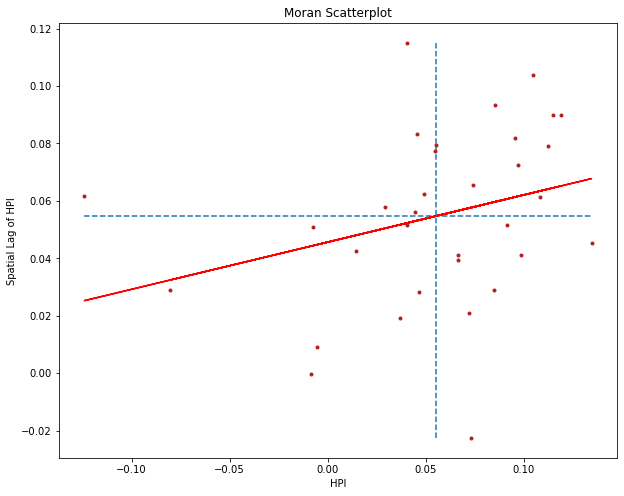

In [123]:
HPI=gdf_house['HPI']
b,a = np.polyfit(HPI, HPI_Lag, 1)
f, ax = plt.subplots(1, figsize=(10, 8))
plt.plot(HPI, HPI_Lag, '.', color='firebrick')

# dashed vert at mean of the last year's private rent level
plt.vlines(HPI.mean(), HPI_Lag.min(), HPI_Lag.max(), linestyle='--')
# dashed horizontal at mean of lagged private rent
plt.hlines(HPI_Lag.mean(), HPI.min(), HPI.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HPI, a + b*HPI, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HPI')
plt.xlabel('HPI')
plt.savefig('./Figures/Moran_Scatterplot.png')

In [95]:
# call moran function
mi = esda.moran.Moran(gdf_house['HPI'], w_queen) 
# print out the moran's I value
print("The moran's I value is {} with p-value of {} and z-score of {}".format(mi.I, mi.p_sim, mi.z_sim))

The moran's I value is 0.16432633733039628 with p-value of 0.038 and z-score of 2.0198718589383113


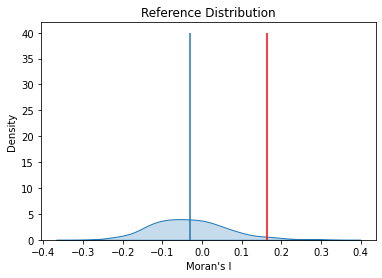

In [115]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 40, color='r')
plt.vlines(mi.EI, 0, 40)
plt.xlabel("Moran's I")
plt.title("Reference Distribution")
plt.savefig('./Figures/Reference_Distribution.png')

### LISA

In [97]:
# Local spatial autocorrelation
lisa = ps.explore.esda.Moran_Local(gdf_house['HPI'].values, w_queen, permutations=999)

In [99]:
gdf_house['lag_HPI'] = ps.lib.weights.lag_spatial(w_queen, gdf_house['HPI'])
sigs = gdf_house['HPI'][lisa.p_sim <= .05]
W_sigs = gdf_house['lag_HPI'][lisa.p_sim <= .05]
insigs = gdf_house['HPI'][lisa.p_sim > .05]
W_insigs = gdf_house['lag_HPI'][lisa.p_sim > .05]

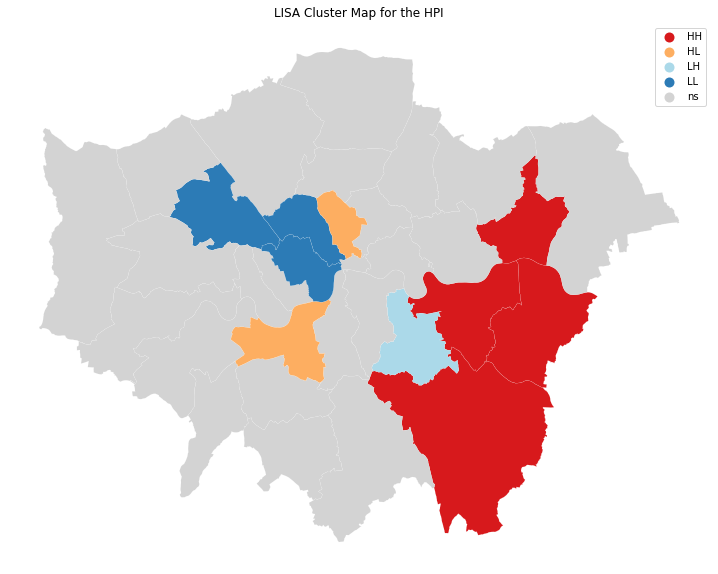

In [114]:
# plot LISA cluster map
from pysal.viz.splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(lisa, gdf_house, ax=ax)
plt.title("LISA Cluster Map for the HPI")
plt.savefig('./Figures/LISA_Cluster_Map.png')
plt.show()

## 3.3	Spatial stratified heterogeneity of the HPI
The geodetector can be downloaded from the website： http://www.geodetector.cn/

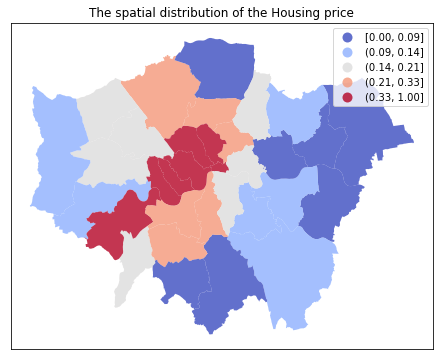

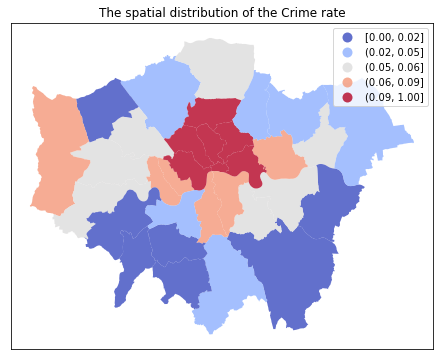

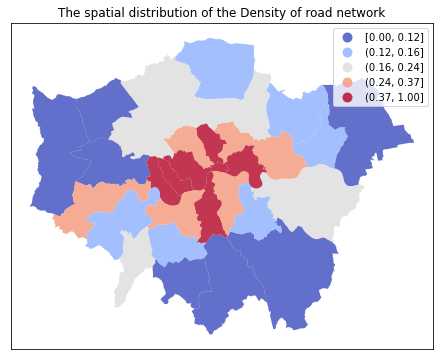

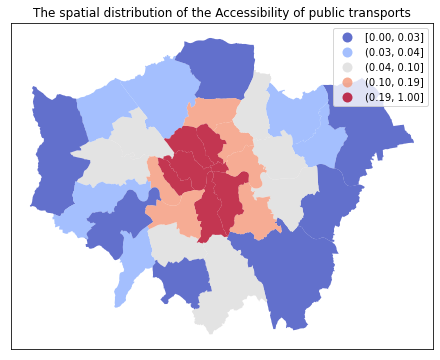

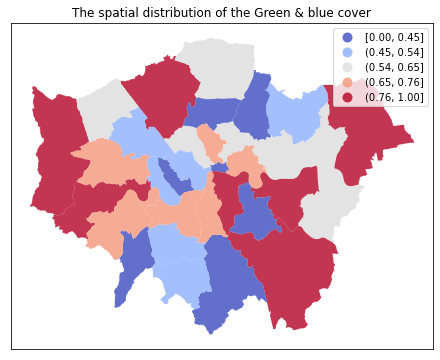

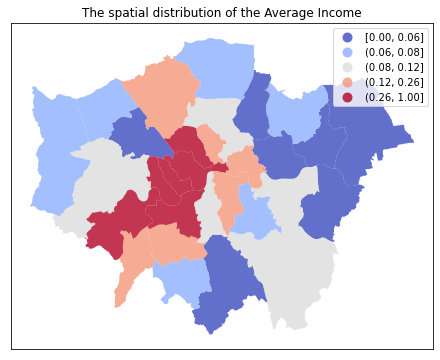

In [126]:
# plot the spatial distribution of other attributes
factors = ['AvHP2020', 'Crime2020', 'TotalRL202', 'AvPTAI2015', 'Per_GB','AvIncome']
name = ['Housing price', 'Crime rate', 'Density of road network', 'Accessibility of public transports','Green & blue cover', 'Average Income']
for i,j in zip(factors,name):
    gdf_house.plot(column=i, alpha=0.8, cmap='coolwarm', scheme='quantiles', legend = True, figsize = (10,6))
    plt.title("The spatial distribution of the {}".format(j)) # set title
    plt.gca().xaxis.set_major_locator(plt.NullLocator())# delete the x-axis
    plt.gca().yaxis.set_major_locator(plt.NullLocator())# delete the y-axis
    plt.savefig('./Figures/{}.png'.format(j))